# This is a multi-linear Regression problem to predict no of Heat/Hot Water cases

## Import libraries and previous saved file

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import statsmodels.api as sm
import statsmodels.formula.api as smf
warnings.filterwarnings("ignore")
%matplotlib inline

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler  
from sklearn.pipeline import make_pipeline 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from xgboost import plot_importance


## Data Exploration and Feature Selection for combined file

In [2]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share your notebook.
client_********** = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='********',
    ibm_auth_endpoint="https://iam.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_*********.get_object(Bucket='********',Key='**********')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df = pd.read_csv(body)



In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86590 entries, 0 to 86589
Data columns (total 18 columns):
BldgArea        86590 non-null int64
BldgDepth       86590 non-null float64
BuiltFAR        86590 non-null float64
CommFAR         86590 non-null float64
FacilFAR        86590 non-null float64
Lot             86590 non-null int64
LotArea         86590 non-null int64
LotDepth        86590 non-null float64
NumBldgs        86590 non-null int64
NumFloors       86590 non-null float64
OfficeArea      86590 non-null int64
ResArea         86590 non-null int64
ResidFAR        86590 non-null float64
RetailArea      86590 non-null int64
YearBuilt       86590 non-null int64
YearAlter1      86590 non-null int64
incident_zip    86590 non-null int64
Count           86590 non-null int64
dtypes: float64(7), int64(11)
memory usage: 11.9 MB


In [4]:
df.head()

,BldgArea,BldgDepth,BuiltFAR,CommFAR,FacilFAR,Lot,LotArea,LotDepth,NumBldgs,NumFloors,OfficeArea,ResArea,ResidFAR,RetailArea,YearBuilt,YearAlter1,incident_zip,Count
0,0,0.0,0.00,5.0,6.5,1,15000,200.0,1,0.0,0,0,6.02,0,2019,2019,10454,1649
1,752,16.0,0.05,5.0,6.5,4,13770,100.0,2,1.0,272,0,6.02,0,88,25,10454,1649
2,39375,200.0,1.13,5.0,6.5,10,35000,200.0,1,2.0,0,0,6.02,0,88,2019,10454,1649
3,12500,85.0,5.00,5.0,6.5,17,2500,100.0,1,5.0,0,12500,6.02,0,88,18,10454,1649
4,8595,70.0,4.58,5.0,6.5,18,1875,75.0,1,5.0,0,6876,6.02,1719,99,10,10454,1649


In [5]:
df.shape

(86590, 18)

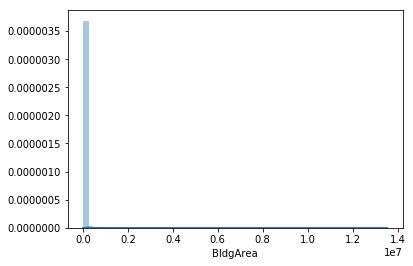

In [6]:
sns.distplot(df['BldgArea'])

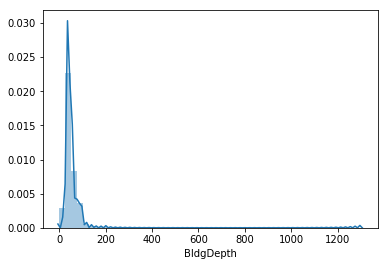

In [7]:
sns.distplot(df['BldgDepth'])

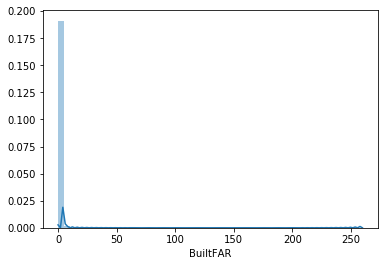

In [8]:
sns.distplot(df['BuiltFAR'])

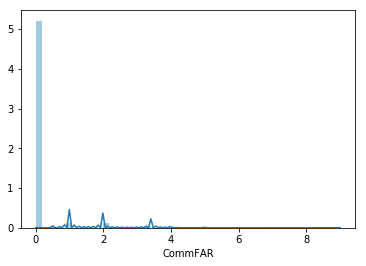

In [9]:
sns.distplot(df['CommFAR'])

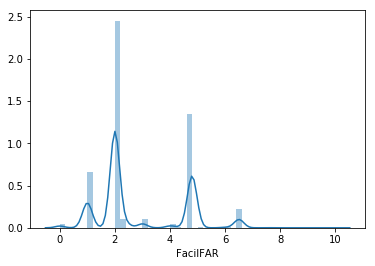

In [10]:
sns.distplot(df['FacilFAR'])

In [11]:
# dropping incident_zip and Lot 
df = df.drop(['incident_zip', 'Lot'], axis=1)
df.head()

,BldgArea,BldgDepth,BuiltFAR,CommFAR,FacilFAR,LotArea,LotDepth,NumBldgs,NumFloors,OfficeArea,ResArea,ResidFAR,RetailArea,YearBuilt,YearAlter1,Count
0,0,0.0,0.00,5.0,6.5,15000,200.0,1,0.0,0,0,6.02,0,2019,2019,1649
1,752,16.0,0.05,5.0,6.5,13770,100.0,2,1.0,272,0,6.02,0,88,25,1649
2,39375,200.0,1.13,5.0,6.5,35000,200.0,1,2.0,0,0,6.02,0,88,2019,1649
3,12500,85.0,5.00,5.0,6.5,2500,100.0,1,5.0,0,12500,6.02,0,88,18,1649
4,8595,70.0,4.58,5.0,6.5,1875,75.0,1,5.0,0,6876,6.02,1719,99,10,1649


### Use Pearson correlation

In [12]:
sns.set_style("whitegrid")

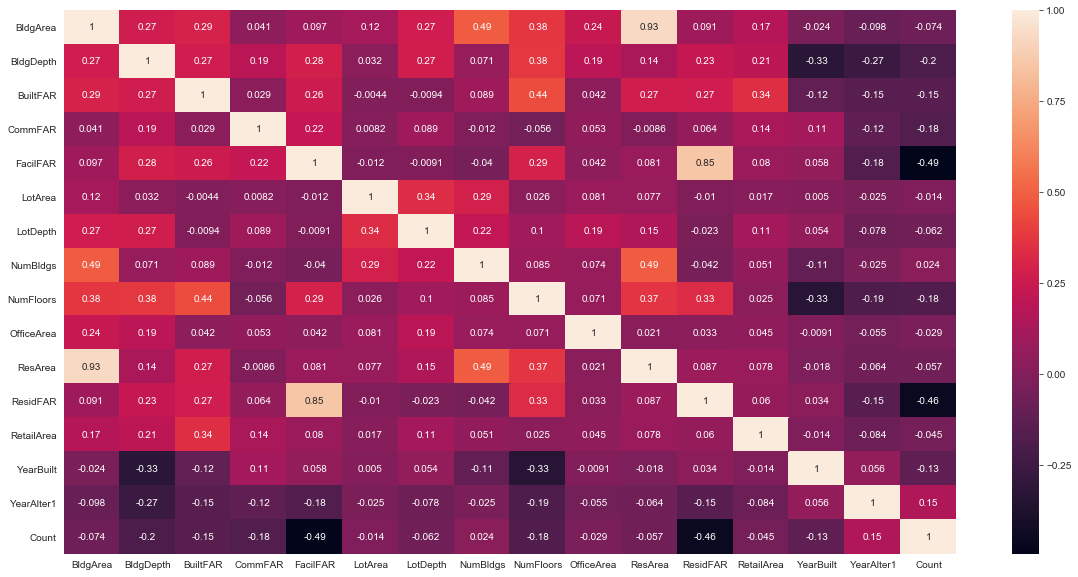

In [13]:
plt.figure(figsize=(20,10))
sns.heatmap(df.corr(),annot=True)

#### Note: There are 4 variables are highly correlated to each other: ResArea,BldgArea; ResidFAR,FacilFAR. Will drop 4 columns before model creation.

## Data cleaning

### Decide output variable

In [14]:
df.shape

(86590, 16)

In [15]:
df.drop(['BldgArea','ResidFAR','ResArea','FacilFAR'], axis=1, inplace=True)

In [16]:
df.head()

,BldgDepth,BuiltFAR,CommFAR,LotArea,LotDepth,NumBldgs,NumFloors,OfficeArea,RetailArea,YearBuilt,YearAlter1,Count
0,0.0,0.00,5.0,15000,200.0,1,0.0,0,0,2019,2019,1649
1,16.0,0.05,5.0,13770,100.0,2,1.0,272,0,88,25,1649
2,200.0,1.13,5.0,35000,200.0,1,2.0,0,0,88,2019,1649
3,85.0,5.00,5.0,2500,100.0,1,5.0,0,0,88,18,1649
4,70.0,4.58,5.0,1875,75.0,1,5.0,0,1719,99,10,1649


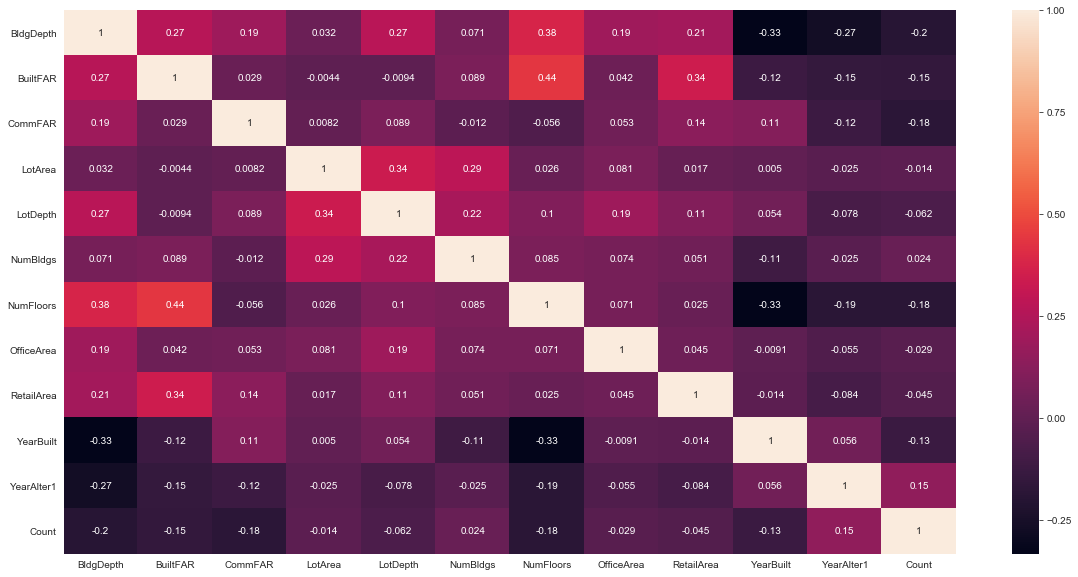

In [17]:
plt.figure(figsize=(20,10))
sns.heatmap(df.corr(),annot=True)

In [18]:
#Let Count column be target variable
X = df.drop('Count',axis=1)
y = df['Count'] #Target variable

In [19]:
X.shape

(86590, 11)

In [20]:
y.shape

(86590,)

## Scaling data

In [21]:
# scaling the features
from sklearn.preprocessing import scale

cols = X.columns
X = pd.DataFrame(scale(X))
X.columns = cols
X.columns

Index(['BldgDepth', 'BuiltFAR', 'CommFAR', 'LotArea', 'LotDepth', 'NumBldgs',
       'NumFloors', 'OfficeArea', 'RetailArea', 'YearBuilt', 'YearAlter1'],
      dtype='object')

In [22]:
X.head()

,BldgDepth,BuiltFAR,CommFAR,LotArea,LotDepth,NumBldgs,NumFloors,OfficeArea,RetailArea,YearBuilt,YearAlter1
0,-1.644076,-0.631790,8.685636,0.019540,1.503515,-0.122500,-1.630247,-0.042899,-0.072480,4.882986,0.316820
1,-1.116455,-0.604171,8.685636,0.015343,-0.078509,0.428041,-0.936558,-0.020579,-0.072480,-0.171265,-3.149488
2,4.951186,-0.007592,8.685636,0.087785,1.503515,-0.122500,-0.242869,-0.042899,-0.072480,-0.171265,0.316820
3,1.158910,2.130149,8.685636,-0.023114,-0.078509,-0.122500,1.838198,-0.042899,-0.072480,-0.171265,-3.161657
4,0.664265,1.898146,8.685636,-0.025246,-0.474015,-0.122500,1.838198,-0.042899,0.271188,-0.142473,-3.175564


In [23]:
# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8,test_size = 0.2, random_state=42)

In [24]:
X_train.shape

(69272, 11)

In [25]:
X_test.shape

(17318, 11)

## Model 1: Linear Regression method

In [26]:
lm = LinearRegression()

In [27]:
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [28]:
# print coefficients and intercept
print(lm.coef_)
print(lm.intercept_)

[-546.41563885 -173.40973255 -417.12736477  -58.41656591   84.91022844
   81.2729661  -570.01777417   82.25586484   93.83754391 -751.34663992
  220.11376071]
5456.409402662075


In [29]:
# predict 
y_pred = lm.predict(X_test)

In [30]:
print(r2_score(y_true=y_test, y_pred=y_pred))

0.13014860104614379


#### R2 score very low at 13%.

## Model 2: Random Forest method

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
X_train.shape

(69272, 11)

In [33]:
X_test.shape

(17318, 11)

In [34]:
forest = RandomForestRegressor(n_estimators=500, criterion='mse', 
                               random_state=42, n_jobs=-1)

In [35]:
forest.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [36]:
y_pred = forest.predict(X_test)

In [37]:
print(r2_score(y_true=y_test, y_pred=y_pred))

0.5699971649811476


#### R2 score went up to 57%.

## Model 3: XGBoost method

In [38]:
xgb_reg = XGBRegressor(max_depth=5,n_estimators=2500,n_jobs=-1)

In [39]:
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=2500,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [40]:
y_test_pred = xgb_reg.predict(X_test)

In [41]:
print(r2_score(y_true=y_test, y_pred=y_test_pred))

0.5072275558014293


#### R2 scores lower than Random Forest that is 51%

In [54]:
df2 = pd.DataFrame({'Model': ['Linear','Random Forest','XG Boost'],'R2_Score': [0.1302, 0.5699, 0.5072]})

In [55]:
df2

,Model,R2_Score
0,Linear,0.1302
1,Random Forest,0.5699
2,XG Boost,0.5072


Text(0.5, 1.0, 'Comparison for all three models')

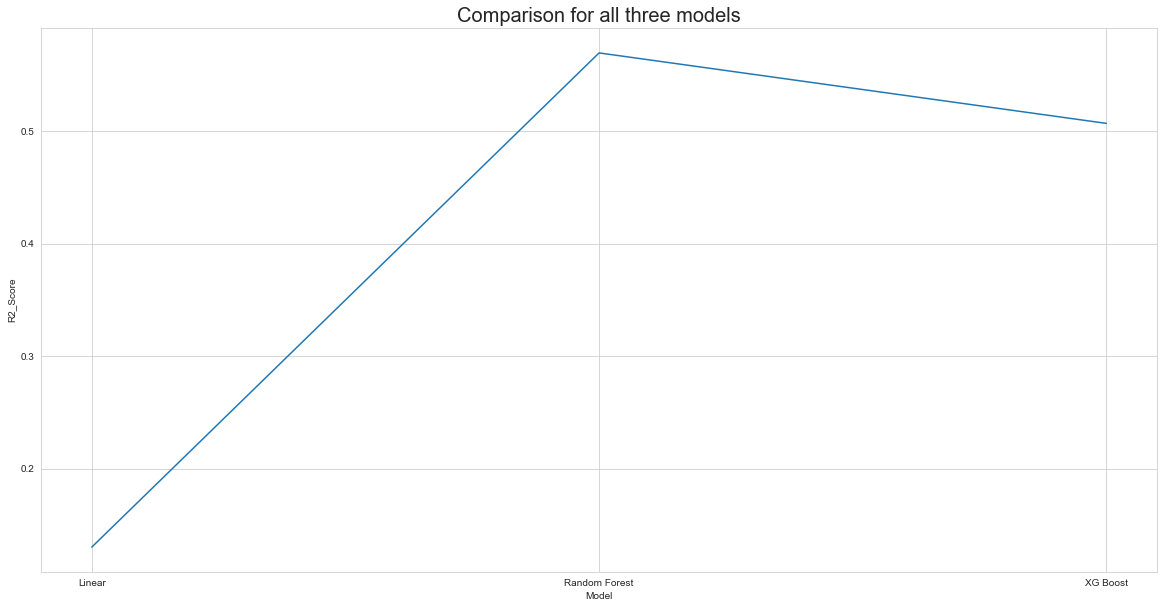

In [66]:
plt.figure(figsize=(20,10))
sns.lineplot(x=df2.Model,y=df2.R2_Score)
plt.title("Comparison for all three models", size=20)

### Interesting Reading:

<b>From MiniTab Editor Blog:</b>

Are Low R-squared Values Inherently Bad?

No! There are two major reasons why it can be just fine to have low R-squared values.

In some fields, it is entirely expected that your R-squared values will be low. For example, any field that attempts to predict human behavior, such as psychology, typically has R-squared values lower than 50%. Humans are simply harder to predict than, say, physical processes.

Furthermore, if your R-squared value is low but you have statistically significant predictors, you can still draw important conclusions about how changes in the predictor values are associated with changes in the response value. Regardless of the R-squared, the significant coefficients still represent the mean change in the response for one unit of change in the predictor while holding other predictors in the model constant. Obviously, this type of information can be extremely valuable.

Are High R-squared Values Inherently Good?

No! A high R-squared does not necessarily indicate that the model has a good fit. 

## Concluding Remarks - The models created are mostly average to low acceptable predictable results. Department of Housing Preservation and Development can start with Random Forest model for a few months to test it out. 

## More models need to be developed such as Support Vector Regression (SVR), K Nearest Neighbours(kNN), Decision Trees (DT), Gradient Boosted Machine(GBM) etc to test their prediction performance and trial basis.

## In short: There is no perfect regression algorithm. The ML algorithm you choose will depend on a variety of factors.